In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

from osgeo import osr

import pickle

import pyart

import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches

In [3]:
import os

os.environ['LC_NUMERIC']='C'

Read the radar grid coordinates. These coordinates are in WGS84 CRS.

In [4]:
# Getting back the objects:
with open('radar_grid.pkl','rb') as f:  # Python 3: open(..., 'rb')
    x_rad, y_rad = pickle.load(f)

Read the watershed shapefile.

In [7]:
# this file is in UTM
#fname_shp = r'C:/Users/iac6311/Documents/Work/Data/GIS/USA/CHI_shps/city_detailed_fixed_utm.shp'
#fname_shp = r'C:/Users/iac6311/Documents/Work/Data/GIS/USA/CHI_shps/city_detailed_subset_utm2.shp'
#fname_shp = r'C:/Users/iac6311/Documents/Work/Data/GIS/USA/CHI_shps/merged.shp'
#fname_shp = r'C:/Users/iac6311/Documents/Work/Data/GIS/USA/CHI_shps/section.shp'
fname_shp = r'C:/Users/iac6311/Documents/Work/Data/GIS/USA/CHI_shps/chi_detailed_south.shp'

In [8]:
dataset, inLayer = wrl.io.open_vector(fname_shp)
borders, keys = wrl.georef.get_vector_coordinates(inLayer, key='objectid')

Define different projections that will be used in the processing.

In [9]:
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

proj_IL = osr.SpatialReference()
proj_IL.ImportFromEPSG(26771)

proj_IL_UTM = osr.SpatialReference()
proj_IL_UTM.ImportFromEPSG(26916)

0

Put the two coordinate grids in one array.

In [10]:
grid_xy = np.zeros((300,300,2))

grid_xy[:,:,0] = x_rad
grid_xy[:,:,1] = y_rad

Reproject the radar grid to UTM, to match the shapefile.

In [11]:
grid_xy_utm = wrl.georef.reproject(grid_xy,
                                projection_source=proj_wgs,
                                projection_target=proj_IL_UTM)

Create a mask to reduce size.

In [13]:
# Reduce grid size using a bounding box (to enhancing performance)
bbox = inLayer.GetExtent()

In [14]:
print(bbox) # in UTM

(433389.248740738, 454779.5486613845, 4619774.645695409, 4637594.562184934)


In [15]:
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
mask = (((grid_xy_utm[..., 1] > bbox['bottom']) & (grid_xy_utm[..., 1] < bbox['top'])) &
        ((grid_xy_utm[..., 0] > bbox['left']) & (grid_xy_utm[..., 0] < bbox['right'])))

In [16]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Have a look at the mask.

(300, 300)


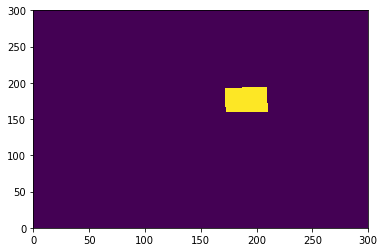

In [17]:
print(mask.shape)
plt.pcolormesh(mask)

In [18]:
# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE COORDINATES)

grdverts = wrl.zonalstats.grid_centers_to_vertices(x_rad[mask],
                                                   y_rad[mask], 0.01,
                                                   0.01)

In [70]:
x_rad

array([[-89.53860964, -89.52888271, -89.51915575, ..., -86.64917921,
        -86.63945225, -86.62972532],
       [-89.53877123, -89.52904323, -89.51931519, ..., -86.64901978,
        -86.63929173, -86.62956373],
       [-89.53893288, -89.52920379, -89.51947467, ..., -86.64886029,
        -86.63913117, -86.62940208],
       ...,
       [-89.58898186, -89.57891828, -89.56885465, ..., -86.59948031,
        -86.58941668, -86.5793531 ],
       [-89.5891599 , -89.57909512, -89.56903031, ..., -86.59930466,
        -86.58923984, -86.57917506],
       [-89.58933799, -89.57927202, -89.56920602, ..., -86.59912894,
        -86.58906294, -86.57899697]])

In [19]:
# And reproject to Cartesian reference system (here: UTM)
grdverts = wrl.georef.reproject(grdverts,
                                projection_source=proj_wgs,
                                projection_target=proj_IL_UTM)

In [20]:
grdverts.shape

(1287, 5, 2)

In [45]:
x_rad

array([[-89.53860964, -89.52888271, -89.51915575, ..., -86.64917921,
        -86.63945225, -86.62972532],
       [-89.53877123, -89.52904323, -89.51931519, ..., -86.64901978,
        -86.63929173, -86.62956373],
       [-89.53893288, -89.52920379, -89.51947467, ..., -86.64886029,
        -86.63913117, -86.62940208],
       ...,
       [-89.58898186, -89.57891828, -89.56885465, ..., -86.59948031,
        -86.58941668, -86.5793531 ],
       [-89.5891599 , -89.57909512, -89.56903031, ..., -86.59930466,
        -86.58923984, -86.57917506],
       [-89.58933799, -89.57927202, -89.56920602, ..., -86.59912894,
        -86.58906294, -86.57899697]])

In [63]:
y_rad

array([[40.48902186, 40.48914524, 40.48926779, ..., 40.48926779,
        40.48914524, 40.48902186],
       [40.49641948, 40.49654288, 40.49666546, ..., 40.49666546,
        40.49654288, 40.49641948],
       [40.5038171 , 40.50394053, 40.50406312, ..., 40.50406312,
        40.50394053, 40.5038171 ],
       ...,
       [42.68609643, 42.68622594, 42.68635458, ..., 42.68635458,
        42.68622594, 42.68609643],
       [42.69349392, 42.69362345, 42.69375211, ..., 42.69375211,
        42.69362345, 42.69349392],
       [42.70089141, 42.70102096, 42.70114964, ..., 42.70114964,
        42.70102096, 42.70089141]])

In [46]:
grdverts[0]

array([[ 428721.15838172, 4614257.85157604],
       [ 429553.5216668 , 4614249.62713878],
       [ 429564.42839824, 4615359.86822301],
       [ 428732.19400353, 4615368.09299875],
       [ 428721.15838172, 4614257.85157604]])

428721.158381715
4614257.851576044
429553.5216668004
4614249.627138784
429564.4283982355
4615359.868223009
428732.1940035303
4615368.092998754
428721.158381715
4614257.851576044


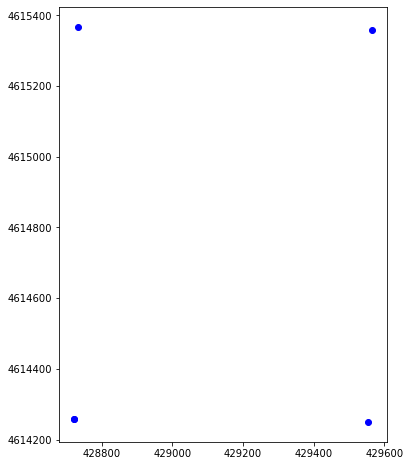

In [61]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

for i in range(len(grdverts[0])):
    print(grdverts[0][i][0])
    print(grdverts[0][i][1])
    x = grdverts[0][i][0]
    y = grdverts[0][i][1]
    ax.plot(x,y,'bo')
    #plt.set_xlim(np.min(grdverts[0])-100,)

In [56]:
np.min(grdverts[0])

428721.158381715

Create instance of type ZonalDataPoly from source grid and catchment array. This needs to be done only once, then dump to file. The files that will be saved are the `src` shapefile (radar pixels), `trg` shapefile (original catchment), and `dst` shapefile (the radar pixels cut according to `trg`). 

In [22]:
borders

array([array([[ 447802.07029978, 4634919.30005241],
       [ 447756.22093264, 4634918.81172901],
       [ 447755.42590386, 4634993.46502646],
       [ 447754.08004653, 4635119.84964084],
       [ 447753.18598622, 4635203.80238042],
       [ 447773.15518787, 4635204.01506921],
       [ 447773.81456342, 4635142.09319788],
       [ 447767.44503807, 4635142.02541204],
       [ 447767.84222957, 4635104.7241626 ],
       [ 447807.89691715, 4635105.15064645],
       [ 447808.90319405, 4635010.65599882],
       [ 447801.09829847, 4635010.57290015],
       [ 447802.07029978, 4634919.30005241]]),
       array([[ 447802.07029978, 4634919.30005241],
       [ 447756.22093264, 4634918.81172901],
       [ 447755.42590386, 4634993.46502646],
       [ 447754.08004653, 4635119.84964084],
       [ 447753.18598622, 4635203.80238042],
       [ 447773.15518787, 4635204.01506921],
       [ 447773.81456342, 4635142.09319788],
       [ 447767.44503807, 4635142.02541204],
       [ 447767.84222957, 4635104.72416

In [23]:
%%time
# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(grdverts, borders)

Wall time: 4.28 s


In [24]:
%%time
# dump to file
zd.dump_vector('zonal_poly_cart_south')

Wall time: 314 ms


In [25]:
%%time
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

Wall time: 1min 8s


Read the gridded data.

In [26]:
data, attrs = wrl.io.from_hdf5('output/gridded_KLOT20130418_070000.hdf5')

# # Getting back the objects:
# with open('radarparams.pkl','rb') as f:  # Python 3: open(..., 'rb')
#     sitecoords, az, r = pickle.load(f)

Preview the gridded data.

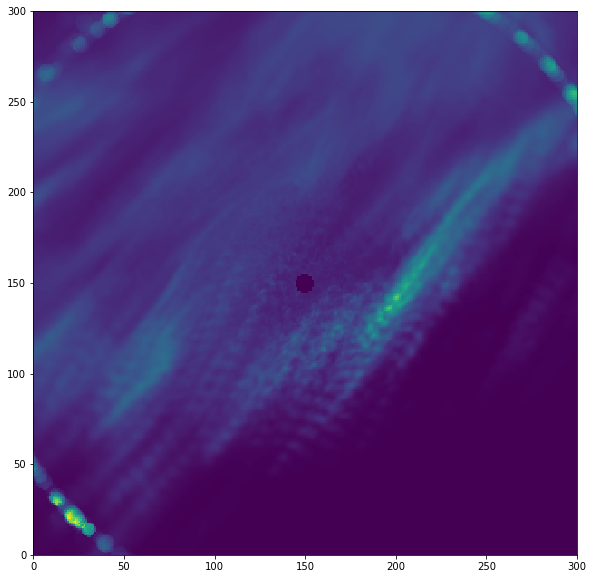

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect='equal')
plt.pcolormesh(data)

Mask the data to reduce size. 

In [28]:
data_ = data[mask]

In [29]:
# Compute stats for target polygons
avg3 = obj3.mean(data_.ravel())

In [30]:
def testplot(cats, catsavg, xy, data,
             levels=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100],
             title=""):
    """Quick test plot layout for this example file
    """
    colors = plt.cm.viridis(np.linspace(0, 1, len(levels)))
    mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

    radolevels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100]
    radocolors = pyart.graph.cm_colorblind.HomeyerRainbow(np.linspace(0, 1, len(radolevels)))
    #pyart.graph.cm_colorblind()
    radocmap, radonorm = from_levels_and_colors(radolevels, radocolors,
                                                extend="max")

    fig = plt.figure(figsize=(10, 16))

    # Average rainfall sum
    ax = fig.add_subplot(211, aspect="equal")
    coll = PatchCollection(cats, array=catsavg, cmap=radocmap, norm=mynorm,
                           edgecolors='white', lw=0.5)
    ax.add_collection(coll)
    ax.autoscale()
    plt.colorbar(coll, ax=ax, shrink=0.5)
    plt.xlabel("NAD83 Z16 Easting")
    plt.ylabel("NAD83 Z16 Northing")
    plt.title(title)
    plt.draw()

    # Original radar data
    ax1 = fig.add_subplot(212, aspect="equal")
    pm = plt.pcolormesh(xy[:, :, 0], xy[:, :, 1], np.ma.masked_invalid(data),
                        cmap=radocmap, norm=radonorm)
    coll = PatchCollection(cats, facecolor='None', edgecolor='k', lw=0.5)
    ax1.add_collection(coll)
    cb = plt.colorbar(pm, ax=ax1, shrink=0.5)
    cb.set_label("(mm/h)")
    plt.xlabel("NAD83 Z16 Easting")
    plt.ylabel("NAD83 Z16 Northing")
    plt.title("Original radar rain sums")
    ax1.set_xlim(bbox['left']-10000,bbox['right']+10000)
    ax1.set_ylim(bbox['bottom']-10000,bbox['top']+10000)
    plt.draw()
    plt.tight_layout()

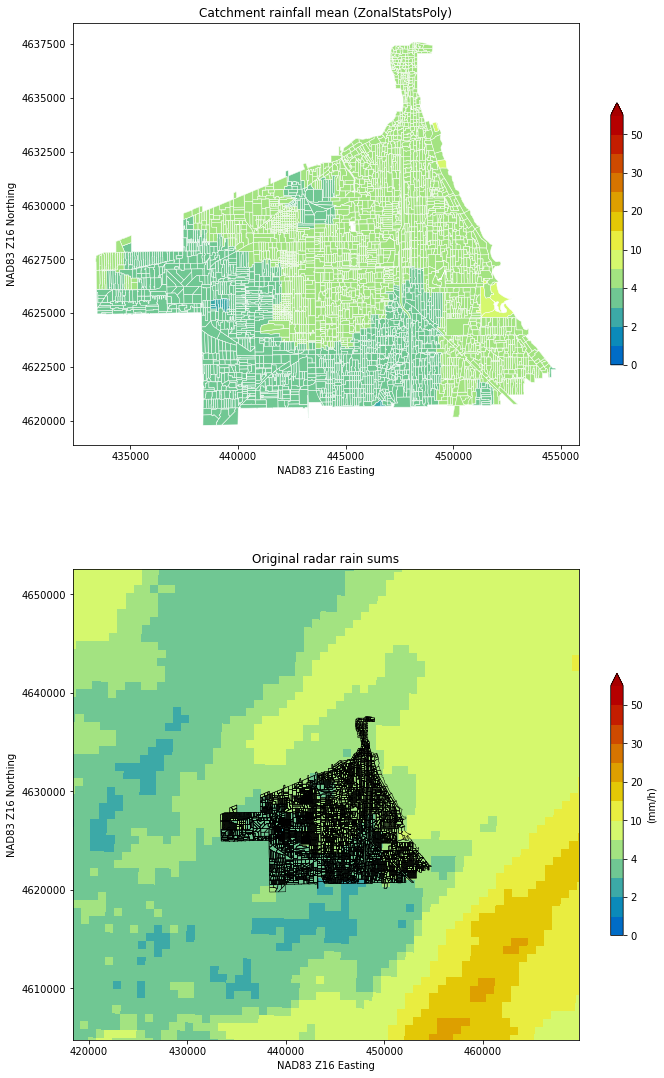

In [31]:
# PLOTTING Approach #2

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj3.zdata.trg.data]

# Plot average rainfall and original data
testplot(trg_patches, avg3, grid_xy_utm, data,
         title="Catchment rainfall mean (ZonalStatsPoly)")

In [32]:
len(trg_patches)

6772

In [33]:
keys

[6872,
 6873,
 6874,
 6875,
 6876,
 6877,
 6878,
 6879,
 6880,
 6883,
 6886,
 6887,
 6888,
 6889,
 6890,
 6891,
 6892,
 6893,
 6894,
 6895,
 6896,
 6897,
 6898,
 6899,
 6900,
 6901,
 6902,
 6903,
 6904,
 6905,
 6906,
 6907,
 6908,
 6909,
 6910,
 6911,
 6912,
 6913,
 6914,
 6915,
 6916,
 6917,
 6918,
 6919,
 6920,
 6921,
 6922,
 6923,
 6924,
 6925,
 6926,
 6927,
 6928,
 6929,
 6930,
 6931,
 6932,
 6933,
 6934,
 6935,
 6936,
 6937,
 6938,
 6939,
 6940,
 6941,
 6942,
 6943,
 6944,
 6945,
 6946,
 6947,
 6948,
 6949,
 6950,
 6951,
 6952,
 6953,
 6954,
 6955,
 6956,
 6957,
 6958,
 6959,
 6960,
 6961,
 6962,
 6963,
 6964,
 6965,
 6966,
 6967,
 6968,
 6969,
 6970,
 6971,
 6972,
 6973,
 6974,
 6975,
 6976,
 6977,
 6978,
 6979,
 6980,
 6981,
 6982,
 6983,
 6984,
 6985,
 6986,
 6987,
 6988,
 6989,
 6990,
 6991,
 6992,
 6993,
 6994,
 6995,
 6996,
 6997,
 6998,
 6999,
 7000,
 7001,
 7002,
 7003,
 7004,
 7005,
 7006,
 7007,
 7008,
 7009,
 7010,
 7011,
 7012,
 7013,
 7014,
 7015,
 7016,
 7017,
 7018,

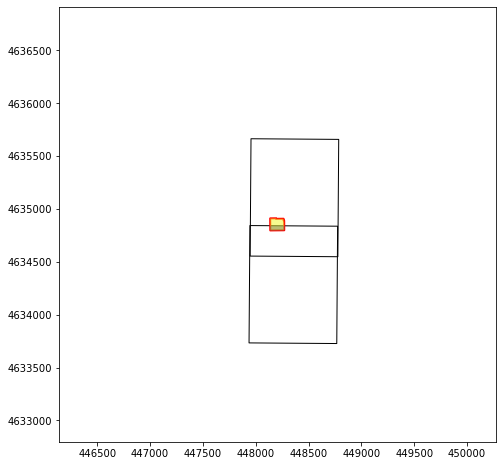

In [40]:

# Illustrate results for an example catchment i
i = 4  # try any index between 0 and 13
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Grid cell patches
src_index = obj3.zdata.get_source_index(i)
grd_patches = [patches.Polygon(item)
               for item in obj3.zdata.src.get_data_by_idx(src_index)]
p = PatchCollection(grd_patches, facecolor="None", edgecolor="black")
ax.add_collection(p)

# Target polygon patches
trg_patch = [trg_patches[i]]
p = PatchCollection(trg_patch, facecolor="None", edgecolor="red",
                    linewidth=2)
ax.add_collection(p)

# View the actual intersections
isecs = obj3.zdata.get_isec(i)
isec_patches = wrl.zonalstats.numpy_to_pathpatch(isecs)
colors = 100 * np.linspace(0, 1., len(isec_patches))
p = PatchCollection(isec_patches, cmap=plt.cm.plasma, alpha=0.5)
p.set_array(np.array(colors))
ax.add_collection(p)

bbox = wrl.zonalstats.get_bbox(borders[i][:, 0], borders[i][:, 1])
plt.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
plt.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
plt.draw()

In [41]:
isecs

array([array([[ 448269.90552659, 4634798.56601899],
       [ 448137.4542229 , 4634797.15545885],
       [ 448137.21234624, 4634841.83300322],
       [ 448269.67649823, 4634840.87295199],
       [ 448269.90552659, 4634798.56601899]]),
       array([[ 448269.90552659, 4634798.56601899],
       [ 448137.4542229 , 4634797.15545885],
       [ 448136.83534027, 4634911.47056191],
       [ 448193.20219945, 4634912.07086251],
       [ 448193.25457428, 4634907.15922221],
       [ 448263.61904409, 4634907.90855976],
       [ 448263.803807  , 4634890.55999082],
       [ 448269.40719458, 4634890.61967826],
       [ 448269.90552659, 4634798.56601899]])], dtype=object)

In [44]:
dir(obj3.zdata)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_buffer',
 '_count_intersections',
 '_create_dst_datasource',
 '_get_idx_weights',
 '_get_intersection',
 '_srs',
 'count_intersections',
 'dst',
 'dump_vector',
 'get_isec',
 'get_source_index',
 'isecs',
 'load_vector',
 'src',
 'srs',
 'tmp_lyr',
 'trg']